In [1]:
# Install compatible versions
!pip install --no-cache-dir torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install --no-cache-dir sympy==1.12  # Required for schnetpack
!pip install --no-cache-dir schnetpack==2.1.1  # Works with sympy 1.12
!pip install --no-cache-dir pytorch-lightning==2.2.1  # Compatible with torch 2.4.1
!pip install --no-cache-dir numpy  # No known issues
!pip install --no-cache-dir ase==3.23

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 857.6/857.6 MB 308.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 339.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 206.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 299.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 MB 161.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 153.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 202.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 207.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 219.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 266.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 191.6 MB/s eta 0:00:00
   ━━━━━━━━━━━

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.5.0.post0
    Uninstalling pytorch-lightning-2.5.0.post0:
      Successfully uninstalled pytorch-lightning-2.5.0.post0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 30.6 MB/s eta 0:00:00
  Attempting uninstall: ase
    Found existing installation: ase 3.24.0
    Uninstalling ase-3.24.0:
      Successfully uninstalled ase-3.24.0


In [1]:
import os
import ase
import schnetpack as spk
from schnetpack.datasets import QM9
from schnetpack.transform import ASENeighborList
import schnetpack.transform as trn

import torch
import torchmetrics
import pytorch_lightning as pl
from schnetpack.data import ASEAtomsData
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''def polarizability_to_tensor(sample):
  new_sample = sample.copy()
  if QM9.alpha in sample:
    alpha = sample[QM9.alpha]
    alpha_val = alpha.item() if isinstance(alpha, torch.Tensor) else alpha
    sample["isotropic_polarizability"] = torch.diag(torch.tensor(
        [alpha_val, alpha_val, alpha_val], dtype=torch.float32
    ))
  return new_sample'''

In [2]:
qm9tut = './qm9tut'
if not os.path.exists('qm9tut'):
  os.makedirs(qm9tut)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is using {device}")

Device is using cuda


# QM9 Preparation

In [4]:
!rm -rf qm9.db split_qm9.npz
qm9data = QM9(
    './qm9.db',
    batch_size =100,
    num_train=110000,
    num_val=10000,
    split_file='./split_qm9.npz',
    transforms=[ASENeighborList(cutoff=5.)]
)
qm9data.prepare_data()
qm9data.setup()

100%|██████████| 133885/133885 [02:01<00:00, 1102.47it/s]


In [67]:
print('Number of reference calculations:', len(qm9data.dataset))
print('Number of train data:', len(qm9data.train_dataset))
print('Number of test data:', len(qm9data.test_dataset))
print('Available properties:')

for p in qm9data.dataset.available_properties:
  print('-', p)

Number of reference calculations: 133885
Number of train data: 110000
Number of test data: 13885
Available properties:
- rotational_constant_A
- rotational_constant_B
- rotational_constant_C
- dipole_moment
- isotropic_polarizability
- homo
- lumo
- gap
- electronic_spatial_extent
- zpve
- energy_U0
- energy_U
- enthalpy_H
- free_energy
- heat_capacity


In [29]:
class PolarizabilityToTensor(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.printed = False

    def forward(self, sample):
        # Print before conversion
        if QM9.alpha in sample:
          if not self.printed:
              print("Before conversion, shape:", sample[QM9.alpha].shape)
          alpha_val = sample[QM9.alpha]
          # If it's a tensor, get the scalar value
          if isinstance(alpha_val, torch.Tensor):
              alpha_val = alpha_val.item()
            # Convert to a 3x3 diagonal tensor
          sample[QM9.alpha] = torch.diag(torch.tensor(
                [alpha_val, alpha_val, alpha_val], dtype=torch.float32))
          if not self.printed:
            # Print after conversion
            print("After conversion, shape:", sample[QM9.alpha].shape)
            self.printed = True
        return sample

    def datamodule(self, dm):
        # Dummy method to satisfy SchNetPack API
        pass

    def teardown(self, stage=None):
        # Dummy teardown method to satisfy Lightning's API.
        pass

In [ ]:
print('Number of reference calculations:', len(qm9data.dataset))
print('Number of train data:', len(qm9data.train_dataset))
print('Number of test data:', len(qm9data.test_dataset))
print('Available properties:')

for p in qm9data.dataset.available_properties:
  print('-', p)

Number of reference calculations: 133885
Number of train data: 1000
Number of test data: 131885
Available properties:
- rotational_constant_A
- rotational_constant_B
- rotational_constant_C
- dipole_moment
- isotropic_polarizability
- homo
- lumo
- gap
- electronic_spatial_extent
- zpve
- energy_U0
- energy_U
- enthalpy_H
- free_energy
- heat_capacity


In [101]:
example = qm9data.dataset[0]
print('Properties:')

for k, v in example.items():
  print('-', k, ':', v.shape)

Properties:
- _idx : torch.Size([1])
- isotropic_polarizability : torch.Size([1])
- _n_atoms : torch.Size([1])
- _atomic_numbers : torch.Size([5])
- _positions : torch.Size([5, 3])
- _cell : torch.Size([1, 3, 3])
- _pbc : torch.Size([3])


In [31]:
for batch in qm9data.val_dataloader():
  print(batch.keys())
  print('Isotropic Polarizability:', batch['isotropic_polarizability'])
  break

Before conversion, shape: torch.Size([1])
After conversion, shape: torch.Size([3, 3])
dict_keys(['_idx', 'isotropic_polarizability', '_n_atoms', '_atomic_numbers', '_positions', '_cell', '_pbc', '_idx_i_local', '_idx_j_local', '_offsets', '_idx_m', '_idx_i', '_idx_j'])
Isotropic Polarizability: tensor([[-8.6711e-01,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -8.6711e-01,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -8.6711e-01],
        [-1.0382e-01,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -1.0382e-01,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.0382e-01],
        [-2.1196e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -2.1196e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -2.1196e+00],
        [-1.2804e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -1.2804e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.2804e+00],
        [-3.0145e-01,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00, -3.0145e-01,  0.0000e+00],
        [ 0.0000e+

In [ ]:
print('system index:', batch['_idx_m'])
print('Center atom index:', batch['_idx_i'])
print('Neighbor atom index:', batch['_idx_j'])

system index: tensor([ 0,  0,  0,  ..., 99, 99, 99])
Center atom index: tensor([   0,    0,    0,  ..., 1731, 1731, 1731])
Neighbor atom index: tensor([   1,    2,    3,  ..., 1712, 1713, 1714])


In [30]:
import ase.units

ase.units.a0 = ase.units.Bohr

qm9data = QM9(
    './qm9.db',
    batch_size=100,
    num_train=1000,
    num_val=1000,
    transforms=[
        trn.ASENeighborList(cutoff=5.),
        trn.RemoveOffsets(QM9.alpha, remove_mean=True, remove_atomrefs=False),
        PolarizabilityToTensor(),
        trn.CastTo32()
    ],
    property_units={QM9.alpha: 'Bohr'},
    num_workers=0,
    split_file=os.path.join(qm9tut, 'split.npz'),
    pin_memory=True,
    load_properties=[QM9.alpha],
)
qm9data.prepare_data()
qm9data.setup()


100%|██████████| 10/10 [00:01<00:00,  8.87it/s]


In [32]:
means, stddevs = qm9data.get_stats(
    QM9.alpha, divide_by_atoms=True, remove_atomref=False
)

print('Mean polarizability energy / atoms:', means.item())
print('Std. dev. polarizability energy / atom:', stddevs.item())

Mean polarizability energy / atoms: 1.1885109179994853
Std. dev. polarizability energy / atom: 0.13662853464305888


# Setting up the model

In [63]:
class AddOffsetsTensor(torch.nn.Module):
    def __init__(self, property_key, offset_tensor=None, add_mean=True, add_atomrefs=False):
        super().__init__()
        self._property = property_key
        self.add_mean = add_mean
        self.add_atomrefs = add_atomrefs
        # If you have a computed offset tensor (of shape [3,3]), store it.
        # Otherwise, default to zero offset.
        if offset_tensor is None:
            self.offset_tensor = torch.zeros(3,3)
        else:
            self.offset_tensor = offset_tensor

    def forward(self, sample):
        # sample[self._property] should be of shape [batch, 3, 3]
        # Expand offset_tensor to match batch size:
        batch_size = sample[self._property].shape[0]
        offset = self.offset_tensor.to(sample[self._property].device).unsqueeze(0).expand(batch_size, -1, -1)
        # Add offset:
        sample[self._property] = sample[self._property] + offset
        return sample

    def datamodule(self, dm):
        pass

    def teardown(self, stage=None):
        pass


In [64]:
cutoff = 5.
n_atom_basis = 40

pairwise_distance = spk.atomistic.PairwiseDistances().to(device)  # calculates pairwise distances between atoms
radial_basis = spk.nn.GaussianRBF(n_rbf=20, cutoff=cutoff).to(device)

schnet = spk.representation.SchNet(
    n_atom_basis=n_atom_basis, n_interactions=6,
    radial_basis=radial_basis,
    cutoff_fn=spk.nn.CosineCutoff(cutoff)
).to(device)

pred_alpha = spk.atomistic.Atomwise(n_in=n_atom_basis, output_key=QM9.alpha, n_out=9).to(device)

class Reshape(torch.nn.Module):
  def __init__(self, key, shape):
    super().__init__()
    self.key = key
    self.shape = shape

  def forward(self, sample):
    batch_size = sample[self.key].shape[0]
    sample[self.key] = sample[self.key].view(batch_size, *self.shape)
    return sample

nnpot = spk.model.NeuralNetworkPotential(
    representation=schnet,
    input_modules=[pairwise_distance],
    output_modules=[pred_alpha],
    postprocessors=[trn.CastTo64(), Reshape(QM9.alpha, (3,3)),
                    AddOffsetsTensor(QM9.alpha, offset_tensor=torch.tensor([0.0,0.0,0.0]).diag())]
).to(device)

In [65]:
import torch
from torchmetrics import Metric

class ReshapedMAE(Metric):
    def __init__(self, dist_sync_on_step: bool = False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        # Sum of absolute errors
        self.add_state("sum_abs_error", default=torch.tensor(0.0), dist_reduce_fx="sum")
        # Total number of elements
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, predicted: torch.Tensor, target: torch.Tensor):
        # If predicted is [batch, 9], reshape it to [batch, 3, 3]
        if predicted.dim() == 2 and predicted.shape[1] == 9:
            predicted = predicted.view(-1, 3, 3)
        # If target is [batch*3, 3], reshape it to [batch, 3, 3]
        if target.dim() == 2 and target.shape[1] == 3 and (target.shape[0] % 3 == 0):
            batch_size = target.shape[0] // 3
            target = target.view(batch_size, 3, 3)
        error = torch.abs(predicted - target)
        self.sum_abs_error += error.sum()
        self.total += error.numel()

    def compute(self):
        return self.sum_abs_error / self.total

class ReshapedRMSE(Metric):
    def __init__(self, dist_sync_on_step: bool = False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        # Sum of squared errors
        self.add_state("sum_squared_error", default=torch.tensor(0.0), dist_reduce_fx="sum")
        # Total number of elements
        self.add_state("total", default=torch.tensor(0), dist_reduce_fx="sum")

    def update(self, predicted: torch.Tensor, target: torch.Tensor):
        if predicted.dim() == 2 and predicted.shape[1] == 9:
            predicted = predicted.view(-1, 3, 3)
        if target.dim() == 2 and target.shape[1] == 3 and (target.shape[0] % 3 == 0):
            batch_size = target.shape[0] // 3
            target = target.view(batch_size, 3, 3)
        error = predicted - target
        self.sum_squared_error += torch.sum(error ** 2)
        self.total += error.numel()

    def compute(self):
        return torch.sqrt(self.sum_squared_error / self.total)


In [66]:
def polarizability_loss(predicted, target):
  #print("Shape of predicted before reshape:", predicted.shape)
  #print("Shape of target before reshape:", target.shape)

  if predicted.dim() == 2 and predicted.shape[1] == 9:
    predicted = predicted.view(-1, 3, 3)
    #print("Reshaped predicted to:", predicted.shape)

  if target.dim() == 2 and target.shape[1] == 3 and (target.shape[0] % 3 == 0):
    batch_size = target.shape[0] // 3
    target = target.view(batch_size, 3, 3)
    #print("Reshaped target to:", target.shape)
  elif target.dim() == 1 or (target.dim() == 2 and target.shape[1] == 1):
    if target.dim() == 1:
      target = target.unsqueeze(1)
    target = target.repeat(1, 3)
    target = torch.diag_embed(target)
    #print("Converted target to diagonal tensor:", target.shape)

  diff = predicted - target
  sample_losses = torch.norm(diff, p='fro', dim=(1, 2))
  loss = sample_losses.mean()

  return loss


output_alpha = spk.task.ModelOutput(
    name=QM9.alpha,
    loss_fn=polarizability_loss,
    loss_weight=1.,
    metrics={
        "MAE" : ReshapedMAE(),
        "RMSE": ReshapedRMSE()
    }
)

In [67]:
task = spk.task.AtomisticTask(
    model=nnpot.to(device),
    outputs=[output_alpha],
    optimizer_cls=torch.optim.AdamW,
    optimizer_args={"lr": 1e-4}
)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


## Training the model

The model is now ready for training. Since we already defined all necessary components, the only thing left to do is passing it to the pytorch Lightning Trainer together with the data module.
Additionally, we can provide callbacks that take care of logging, checkpointing etc.

In [87]:
class LossHistoryCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.history = {"train_loss": [], "val_loss": []}

    def on_validation_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.history["val_loss"].append(val_loss.item())

    def on_train_epoch_end(self, trainer, pl_module, outputs):
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            self.history["train_loss"].append(train_loss.item())


In [103]:
logger = pl.loggers.TensorBoardLogger(save_dir=qm9tut, name="logs")
callbacks = [
    spk.train.ModelCheckpoint(
        model_path=os.path.join(qm9tut, "best_inference_model"),
        save_top_k=1,
        monitor="val_loss"
    )
]
loss_history = LossHistoryCallback()
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,
    callbacks=callbacks,
    logger=False,
    default_root_dir=qm9tut,
    max_epochs=20,
)
trainer.fit(task, datamodule=qm9data)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type                   | Params
---------------------------------------------------
0 | model   | NeuralNetworkPotential | 49.2 K
1 | outputs | ModuleList             | 0     
---------------------------------------------------
49.2 K    Trainable params
0         Non-trainable params
49.2 K    Total params
0.197     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


# Inference

Having trained a model for QM9, we are going to use it to obtain some predictions. First, we need to load the model. The Trainer stores the best model in the model directory which can be loaded using PyTorch.

In [90]:
import torch
import numpy as np
from ase import Atoms

best_model = torch.load(os.path.join(qm9tut, 'best_inference_model'), map_location=device)
best_model.to(device)
best_model.eval()

<ipython-input-90-ef270ef7c833>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load(os.path.join(qm9tut, 'best_inference_model'), map_location=device)


NeuralNetworkPotential(
  (postprocessors): ModuleList(
    (0): CastTo64()
    (1): Reshape()
    (2): AddOffsetsTensor()
  )
  (representation): SchNet(
    (radial_basis): GaussianRBF()
    (cutoff_fn): CosineCutoff()
    (embedding): Embedding(100, 40)
    (electronic_embeddings): ModuleList()
    (interactions): ModuleList(
      (0-5): 6 x SchNetInteraction(
        (in2f): Dense(
          in_features=40, out_features=40, bias=False
          (activation): Identity()
        )
        (f2out): Sequential(
          (0): Dense(in_features=40, out_features=40, bias=True)
          (1): Dense(
            in_features=40, out_features=40, bias=True
            (activation): Identity()
          )
        )
        (filter_network): Sequential(
          (0): Dense(in_features=20, out_features=40, bias=True)
          (1): Dense(
            in_features=40, out_features=40, bias=True
            (activation): Identity()
          )
        )
      )
    )
  )
  (input_modules): Modul

In [91]:
for batch in qm9data.test_dataloader():
  batch = {key: value.to(device) for key, value in batch.items()}

  with torch.no_grad():
    result = best_model(batch)
  print("Result dictionary:", result)
  break

Result dictionary: {'isotropic_polarizability': tensor([[[ 2.9690e-02,  3.0177e-02,  1.9784e-01],
         [-2.8226e-01,  4.3606e-01,  6.0265e-02],
         [-1.6148e-01, -2.9181e-02,  1.4781e-01]],

        [[-3.1405e+00, -1.3617e-01,  4.0726e-01],
         [-1.7568e-01, -3.0958e+00,  1.4993e-01],
         [-5.8332e-02,  2.3065e-01, -3.0246e+00]],

        [[-1.2936e+00,  1.4587e-01, -1.1892e-01],
         [-1.6629e-01, -4.6868e-01, -2.2749e-01],
         [ 1.1670e-01, -1.1955e-01, -1.4631e+00]],

        [[ 1.7100e+00,  1.0922e-02,  1.0276e-01],
         [-1.5191e-01,  1.8561e+00,  3.2794e-01],
         [ 2.5811e-01,  3.5210e-01,  1.5371e+00]],

        [[ 1.4505e+00,  1.5313e+00, -1.8367e-01],
         [-1.9055e-01,  2.3516e+00,  2.4568e-01],
         [ 6.9013e-01, -5.7520e-02,  1.1909e+00]],

        [[-3.3318e+00, -3.0846e-01,  2.6280e-01],
         [-4.6049e-02, -3.4279e+00,  3.7954e-01],
         [-7.9350e-02,  2.3346e-01, -3.1290e+00]],

        [[ 2.5380e+00,  3.5627e-01,  8.8

In [92]:
import torch
from schnetpack.interfaces import AtomsConverter
import schnetpack.transform as trn

def predict_polarizability(atoms_obj, model, device):
  """
  predicts the polarizability of a given molecular structure.

  Args:
      atoms_obj: ASE Atoms object representing a molecule.
      model: Trained SchNet model.
      device: The device where the model runs.

  Return:
      float: Predicted polarizability value.
  """
  # Ensure model is in evaluation mode
  model.eval()

  # Convert ASE Atoms  object to SchNetPack input format
  converter = AtomsConverter(
      neighbor_list=trn.ASENeighborList(cutoff=5.), dtype=torch.float32, device=device
  )
  inputs = converter(atoms_obj)

  #Run inference
  with torch.no_grad():
    result = model(inputs)

    # Debugging: Print available keys if an error occurs
    print("Model output keys:", result.keys())

    # Extract the predicted polarizability 3x3 matrix
    predicted_polarizability = result[QM9.alpha]

    return predicted_polarizability

In [72]:
print("Available keys in the first test sample:", qm9data.test_dataset[0].keys())

Available keys in the first test sample: dict_keys(['_idx', 'isotropic_polarizability', '_n_atoms', '_atomic_numbers', '_positions', '_cell', '_pbc', '_idx_i', '_idx_j', '_offsets'])


In [105]:
from ase import Atoms

# Pick a molecule from the dataset
sample_data = qm9data.test_dataset[0]
atomic_numbers = sample_data["_atomic_numbers"].numpy()  # Convert tensors to NumPy
positions = sample_data["_positions"].numpy()   # Convert tensors to NumPy
atoms_obj = Atoms(numbers=atomic_numbers, positions=positions)

# Convert an ASE Atoms opbject
sample_molecule = Atoms(numbers=atomic_numbers, positions=positions)

# Call the function to predict polarizability
predicted_value = predict_polarizability(sample_molecule, best_model, device)

# Print the predicted value and the actual value
actual_polarizability = sample_data[QM9.alpha]
print(f"Predicted polarizability tensor: {predicted_value}")
print(f"Actual Polarizability: {actual_polarizability}")

Model output keys: dict_keys(['isotropic_polarizability'])
Predicted polarizability tensor: tensor([[[ 0.0297,  0.0302,  0.1978],
         [-0.2823,  0.4361,  0.0603],
         [-0.1615, -0.0292,  0.1478]]], device='cuda:0', dtype=torch.float64)
Actual Polarizability: tensor([[0.1174, 0.0000, 0.0000],
        [0.0000, 0.1174, 0.0000],
        [0.0000, 0.0000, 0.1174]])


In [94]:
converter = spk.interfaces.AtomsConverter(neighbor_list=trn.ASENeighborList(cutoff=5.), dtype=torch.float32)

In [95]:
numbers = np.array([6, 1, 1, 1, 1])
positions = np.array([[-0.0126981359, 1.0858041578, 0.0080009958],
                      [0.002150416, -0.0060313176, 0.0019761204],
                      [1.0117308433, 1.4637511618, 0.0002765748],
                      [-0.540815069, 1.4475266138, -0.8766437152],
                      [-0.5238136345, 1.4379326443, 0.9063972942]])
atoms = Atoms(numbers=numbers, positions=positions)

In [96]:
inputs = converter(atoms)
inputs = {key: value.to(device, non_blocking=True) for key, value in inputs.items()}


print('Keys:', list(inputs.keys()))

'''for key, value in inputs.items():
    print(f"{key}: {value.device}")'''
best_model.eval()

with torch.no_grad():
  pred = best_model(inputs)

print('Prediction:', pred[QM9.alpha])

Keys: ['_n_atoms', '_atomic_numbers', '_positions', '_cell', '_pbc', '_idx', '_idx_i_local', '_idx_j_local', '_offsets', '_idx_m', '_idx_i', '_idx_j']
Prediction: tensor([[[-0.3183, -0.6609,  0.7449],
         [ 0.6709, -0.9770, -0.2635],
         [ 0.1162,  0.1773, -0.2895]]], device='cuda:0', dtype=torch.float64)


# Implementing the Molecule Matching Function

Now that the model fetches the Polarizability, we need a function to:
- Takes a target polarizability (user input).
- Searches the dataset for the closest molecules.
- Returns the top 5 closest matches.

In [97]:
def find_closest_molecules(target_polarizability, dataset, top_k=5):
  """
    Finds molecules in the dataset with polarizability closest to the target value.

    Args:
        target_polarizability (float): The desired polarizability value.
        dataset: The QM9 dataset containing molecular properties.
        top_k (int): Number of closest molecules to return.

    Returns:
        List of closest molecules with their polarizability values and deviations.

  """
  closest_molecules=[]

  # Iterate through the dataset
  for i in range(len(dataset)):
    sample_data = dataset[i]

    # Extract the actual polarizability value
    actual_polarizability = sample_data[QM9.alpha]

    actual_scaler = torch.diag(actual_polarizability).mean().item()

    # Compute absolute difference
    deviation = abs(actual_scaler - target_polarizability)

    # Store results
    closest_molecules.append({
        "index": i,
        "actual_scaler": actual_scaler,
        "actual_polarizability": actual_polarizability,
        "deviation": deviation
    })

  # Sort by deviation (smallest difference first)
  closest_molecules.sort(key=lambda x: x["deviation"])

  # Return the top k closest molecules
  return closest_molecules[:top_k]

## Get the user Input and Find Matches

In [98]:
# Get user input
user_polarizability = float(input("Enter desired polarizability value: "))

# Find matching molecules
matched_molecules = find_closest_molecules(user_polarizability, qm9data.test_dataset, top_k=5)

print("\nMolecules closest to the target polarizability:")
for match in matched_molecules:
  print(f"Index: {match['index']} - Scaler Polarizability: {match['actual_scaler']:.4f} (Deviation: {match['deviation']:.4f})")

  print("Polarizability Tensor: ")
  print(match['actual_polarizability'])

Enter desired polarizability value: 12

Molecules closest to the target polarizability:
Index: 52579 - Scaler Polarizability: 11.9557 (Deviation: 0.0443)
Polarizability Tensor: 
tensor([[11.9557,  0.0000,  0.0000],
        [ 0.0000, 11.9557,  0.0000],
        [ 0.0000,  0.0000, 11.9557]])
Index: 49850 - Scaler Polarizability: 12.0454 (Deviation: 0.0454)
Polarizability Tensor: 
tensor([[12.0454,  0.0000,  0.0000],
        [ 0.0000, 12.0454,  0.0000],
        [ 0.0000,  0.0000, 12.0454]])
Index: 109316 - Scaler Polarizability: 11.9394 (Deviation: 0.0606)
Polarizability Tensor: 
tensor([[11.9394,  0.0000,  0.0000],
        [ 0.0000, 11.9394,  0.0000],
        [ 0.0000,  0.0000, 11.9394]])
Index: 58574 - Scaler Polarizability: 12.0662 (Deviation: 0.0662)
Polarizability Tensor: 
tensor([[12.0662,  0.0000,  0.0000],
        [ 0.0000, 12.0662,  0.0000],
        [ 0.0000,  0.0000, 12.0662]])
Index: 100643 - Scaler Polarizability: 11.9086 (Deviation: 0.0914)
Polarizability Tensor: 
tensor([[11.

# Test and Validate the Matching,

In [ ]:
polarizability_values = [qm9data.test_dataset[i][QM9.alpha].item() for i in range(len(qm9data.test_dataset))]

print("Minimum Polarizability in dataset:", min(polarizability_values))
print("Maximum Polarizability in dataset:", max(polarizability_values))

In [107]:
import matplotlib.pyplot as plt

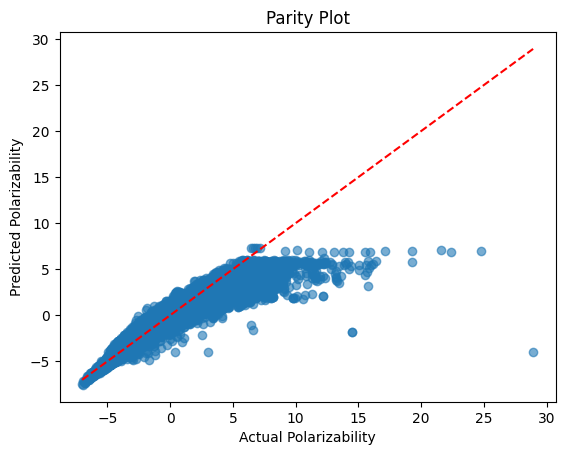

In [106]:
predicted_scalars = []  # e.g., using torch.trace(pred_tensor)/3 for each sample
actual_scalars = []

for sample in qm9data.test_dataset:
    # Assuming sample[QM9.alpha] is a 3x3 tensor
    actual_tensor = sample[QM9.alpha]
    actual_scalar = torch.trace(actual_tensor).item() / 3.0
    actual_scalars.append(actual_scalar)

    # Get model prediction for the sample
    with torch.no_grad():
      atomic_numbers = sample["_atomic_numbers"].numpy()
      positions = sample["_positions"].numpy()
      atoms_obj = Atoms(numbers=atomic_numbers, positions=positions)

      inputs = converter(atoms_obj)  # You may need to convert using your AtomsConverter
      inputs = {key: value.to(device) for key, value in inputs.items()}
      result = best_model(inputs)
      pred_tensor = result[QM9.alpha].squeeze()
      pred_scalar = torch.trace(pred_tensor.squeeze()).item() / 3.0
      predicted_scalars.append(pred_scalar)

plt.figure()
plt.scatter(actual_scalars, predicted_scalars, alpha=0.6)
plt.xlabel('Actual Polarizability')
plt.ylabel('Predicted Polarizability')
plt.plot([min(actual_scalars), max(actual_scalars)], [min(actual_scalars), max(actual_scalars)], 'r--')  # line y=x
plt.title('Parity Plot')
plt.show()